# Find lookup tables mapping high precision classifiers to 
We look for board pattern neurons, that have high recall for any lines and have high precision for the group / union of board patterns.


This notebook always uses the sae_feature_index per default, instead of the alive index

## Setup

In [20]:
# Setup
# Imports
import os
import pickle
from jaxtyping import Union
import json

import torch as t
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
import importlib
import numpy as np
import einops

from circuits.dictionary_learning.dictionary import AutoEncoder, AutoEncoderNew, GatedAutoEncoder, IdentityDict
from circuits.utils import (
    othello_hf_dataset_to_generator,
    get_model,
    get_submodule,
)

from feature_viz_othello_utils import (
    get_acts_IEs_VN,
    plot_lenses,
    plot_mean_metrics,
    plot_top_k_games
)

import circuits.utils as utils
import circuits.analysis as analysis
import feature_viz_othello_utils as viz_utils
from circuits.othello_engine_utils import to_board_label, to_int

device = 'cuda:0'
repo_dir = '/share/u/can/chess-gpt-circuits'
# repo_dir = "/home/adam/chess-gpt-circuits"

In [21]:
model_name = "Baidicoot/Othello-GPT-Transformer-Lens"
model = get_model(model_name, device)

Loaded pretrained model Baidicoot/Othello-GPT-Transformer-Lens into HookedTransformer
Moving model to device:  cuda:0


In [22]:
def get_ae(layer: int, node_type: str):
    if node_type == "sae_feature":
        ae_group_name = 'all_layers_othello_p_anneal_0530_with_lines'
        ae_type = 'p_anneal'
        trainer_id = 0
        ae_path = f'{repo_dir}/autoencoders/{ae_group_name}/layer_{layer}/trainer{trainer_id}'
    elif node_type == "mlp_neuron":
        ae_group_name = 'othello_mlp_acts_identity_aes_lines' # with_lines
        ae_type = 'identity'
        ae_path = f'{repo_dir}/autoencoders/{ae_group_name}/layer_{layer}'
    else:
        raise ValueError('Invalid node_type')

    # download data from huggingface if needed
    if not os.path.exists(f'{repo_dir}/autoencoders/{ae_group_name}'):
        hf_hub_download(repo_id='adamkarvonen/othello_saes', filename=f'{ae_group_name}.zip', local_dir=f'{repo_dir}/autoencoders')
        # unzip the data
        os.system(f'unzip {repo_dir}/autoencoders/{ae_group_name}.zip -d {repo_dir}/autoencoders')

    # Initialize the autoencoder
    if ae_type == 'standard' or ae_type == 'p_anneal':
        ae = AutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
    elif ae_type == 'gated' or ae_type == 'gated_anneal':
        ae = GatedAutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
    elif ae_type == 'standard_new':
        ae = AutoEncoderNew.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
    elif ae_type == 'identity':
        ae = IdentityDict()
    else:
        raise ValueError('Invalid ae_type')
    return ae, ae_path

In [23]:
# Load results files
# load feature analysis results
def to_device(d, device=device):
    if isinstance(d, t.Tensor):
        return d.to(device)
    if isinstance(d, dict):
        return {k: to_device(v, device) for k, v in d.items()}

def load_results_file(ae_path, device):
    with open (os.path.join(ae_path, 'indexing_None_n_inputs_1000_results.pkl'), 'rb') as f:
        results = pickle.load(f)
    return to_device(results, device)

bs_function = 'games_batch_to_state_stack_length_lines_mine_BLRCC'

## Find board pattern neurons
High recall for board patterns and high precision for union of board patterns (restricted to patterns corresponding to at most n_valid_moves)

In [24]:
def find_board_pattern_neurons(
        results: dict, 
        T_recall: float = 0.99, 
        T_precision: float = 0.99, 
        n_valid_moves_per_feat: int = 1, 
        drop_occurences_below: int = 10, 
        verbose: bool=False
    ):
    """
    Find neurons that are active for board patterns with high recall and precision for the union of these patterns.
    drop_occurences_below: int, minimum number of occurences of a board pattern for it to be considered
    """

    epsilon = 1e-6
    recall_TFRRC = results[bs_function]['on'] / (results[bs_function]['all'] + epsilon)

    ## Recall for board patterns
    # Filter out patterns that have less than drop_occurences_below TP
    recall_TFRRC[results[bs_function]['on'] < drop_occurences_below] = 0

    # Lookup table feature, indices with recall above T_recall
    high_recall_TFRRC = (recall_TFRRC > T_recall)

    # Aggregate over T_fire
    high_recall_FRRC = t.any(high_recall_TFRRC, dim=0).int()
    hrc_nonzero = high_recall_FRRC.nonzero()
    if verbose:
        print(f'#features with high recall any board patterns: {hrc_nonzero[:, 0].unique().shape[0]}')

    ## Precision for union of HRC patterns
    # Number of times each feature is active
    total_feature_activations_TF = results['on_count']

    # Number of times feature is active and ANY of the HRC board patterns are present
    feature_activates_on_HRC_pattern_TF = (results[bs_function]['on'] * high_recall_FRRC).sum(dim=(2,3,4))

    # Compute precision
    precision_TF = feature_activates_on_HRC_pattern_TF / (total_feature_activations_TF + epsilon)

    # High precision for any T_fire
    high_precision_TF = (precision_TF > T_precision)
    high_precision_F = high_precision_TF.any(dim=0)
    if verbose:
        print(f'# board pattern union neurons {high_precision_F.sum()}') 

    # Find high precision neurons for union of board patterns AND high recall for individual board patterns
    hpc_mask = t.zeros_like(high_precision_F)
    hpc_mask[high_precision_F] = 1
    union_FRRC = high_recall_FRRC.clone()
    union_FRRC[hpc_mask == 0] = 0

    # Mask out features that correspont to more than n_valid_moves moves
    valid_moves_mask = union_FRRC.any(dim=-1).sum(dim=(1,2)) > n_valid_moves_per_feat
    union_FRRC[valid_moves_mask] = 0

    union_FSLD = einops.rearrange(union_FRRC, 'F R1 R2 (L D) -> F (R1 R2) L D', L=6, D=8)
    return union_FSLD

### Sweep over layers

In [25]:
T_high_corr = 0.95
node_type = "mlp_neuron"
n_neurons = 0

union_neurons_LFSLenDir = t.zeros((model.cfg.n_layers, model.cfg.d_mlp, 64, 6, 8), device=device)
for layer in range(model.cfg.n_layers):
    ae, ae_path = get_ae(layer, node_type)
    with open (os.path.join(ae_path, 'indexing_None_n_inputs_1000_results.pkl'), 'rb') as f:
        results = pickle.load(f)
    results = utils.to_device(results, device)

    union_FSLD = find_board_pattern_neurons(results, T_precision=T_high_corr, T_recall=T_high_corr)
    union_neurons_LFSLenDir[layer] = union_FSLD
    neurons = union_FSLD.any(dim=(1,2,3)).sum()
    n_neurons += neurons
    print(f'MLP layer {layer} contains union neurons: {neurons}')
print(f'Total number of union neurons: {n_neurons}')

## Save
# union_neurons_dict = {layer: union_neurons_LFSLenDir[layer].nonzero().tolist() for layer in range(model.cfg.n_layers)}
# ae_group_name = 'othello_mlp_acts_identity_aes_lines'
# ae_group_path = f'{repo_dir}/autoencoders/{ae_group_name}'

# # Save union neurons as json
# with open(os.path.join(ae_group_path, f'union_neurons-T{thresh}.json'), 'w') as f:
#     json.dump(union_neurons, f)


MLP layer 0 contains union neurons: 2
MLP layer 1 contains union neurons: 0
MLP layer 2 contains union neurons: 1
MLP layer 3 contains union neurons: 14
MLP layer 4 contains union neurons: 107
MLP layer 5 contains union neurons: 247
MLP layer 6 contains union neurons: 152
MLP layer 7 contains union neurons: 104
Total number of union neurons: 627


## Analysis

In [65]:
layer=5
union_FSLD = union_neurons_LFSLenDir[layer]

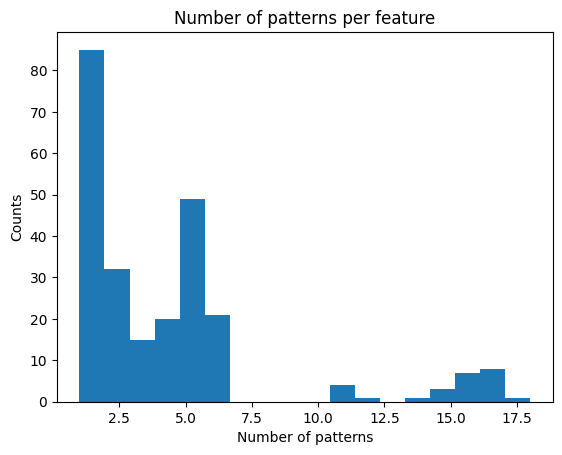

In [66]:
# Number of patterns per feature
n_patterns_per_feature = union_FSLD.sum(dim=(1,2,3))
plt.hist(n_patterns_per_feature[n_patterns_per_feature != 0].cpu().numpy(), bins=max(n_patterns_per_feature).int().item())
plt.xlabel('Number of patterns')
plt.ylabel('Counts')
plt.title('Number of patterns per feature');

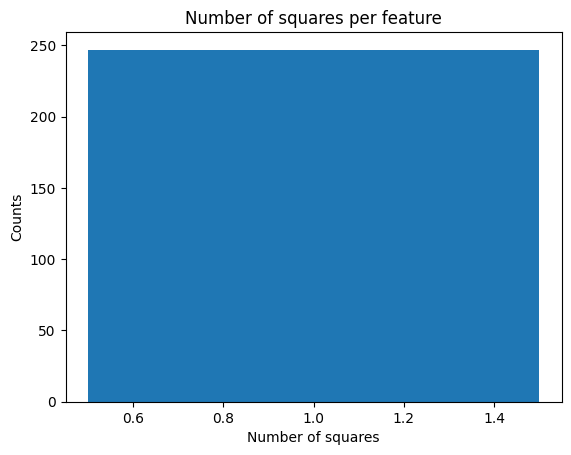

In [67]:
# number of squares per feature
n_squares_per_feature = union_FSLD.any(dim=(-1, -2)).sum(dim=(1))
plt.hist(
    n_squares_per_feature[n_squares_per_feature != 0].cpu().numpy(), 
    bins=n_squares_per_feature.max().item(),
    )
plt.xlabel('Number of squares')
plt.ylabel('Counts')
plt.title('Number of squares per feature');

### Visualize patterns per neuron

In [68]:
eights = [[-1, 0], [-1, 1], [0, 1], [1, 1], [1, 0], [1, -1], [0, -1], [-1, -1]]
color_map = {-1: 'black', 1: 'gold', -9: 'white', -3: 'green'}
color_lbl = {'My piece': -1, 'Their piece': 1, 'Any': -9, 'Valid move': -3}

# Function mapping (Sq, Len, Dir) to a (64,) board tensor
def to_board_tensor(square_idxs, lengths, directions, device, opponent_only=True):
    board_tensor = t.ones((len(square_idxs), 8, 8), device=device) * color_lbl['Any']
    for i, (square_idx, len_idx, dir_idx) in enumerate(zip(square_idxs, lengths, directions)):
        x, y = square_idx // 8, square_idx % 8
        dx, dy = eights[dir_idx]

        if opponent_only is False:
            board_tensor[i, x, y] = color_lbl['Valid move']
        else:
            board_tensor[i, x, y] = color_lbl['No piece']
        for _ in range(1, len_idx + 2):
            x += dx
            y += dy
            if x < 0 or x >= 8 or y < 0 or y >= 8:
                print('Out of bounds')
                break
            board_tensor[i, x, y] = color_lbl['Their piece']

        if opponent_only is False:
            x += dx
            y += dy
            board_tensor[i, x, y] = color_lbl['My piece']
    return board_tensor

def plot_board_categorical(fig, axs, boards, node_idxs, node_type):
    # Define color ma
    colors = list(color_map.values())
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    label_to_enumerate = {label: i for i, label in enumerate(color_map.keys())}
    vmin=0
    vmax=len(color_map)-1
    norm = plt.matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    
    # Plot each board
    for ax, board, feat_idx in zip(axs.flat, boards, node_idxs):
        board_indices = np.vectorize(lambda x: label_to_enumerate[x])(board)
        cax = ax.imshow(board_indices, cmap=cmap, norm=norm)

        # Plot labeling
        ax.set_xticks(range(8))
        ax.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
        # ax.set_yticks(range(8))
        # ax.set_yticklabels(list(range(8)))
        # ax.set_title(f'{node_type} #{feat_idx}', fontsize=10)

    cbar = fig.colorbar(cax, ax=axs, norm=norm, orientation='vertical', ticks=range(len(color_lbl)))
    # cbar.ax.set_xticklabels(list(color_lbl.keys()))
    cbar.ax.set_yticklabels(list(color_lbl.keys()))

# Test
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# btensor = to_board_tensor([0,1,2], [0,1,2], [4, 4, 4], device, opponent_only=False).cpu().detach().numpy()
# plot_board_categorical(fig, axs, btensor, [0,0,0], node_type)

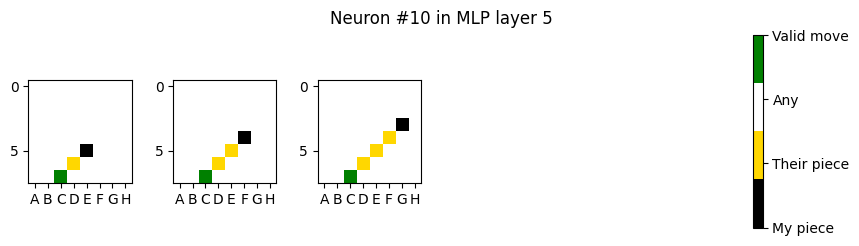

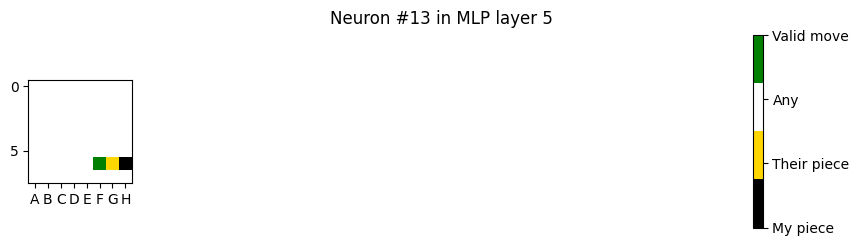

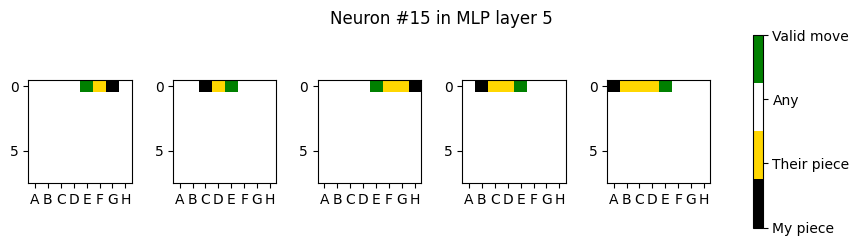

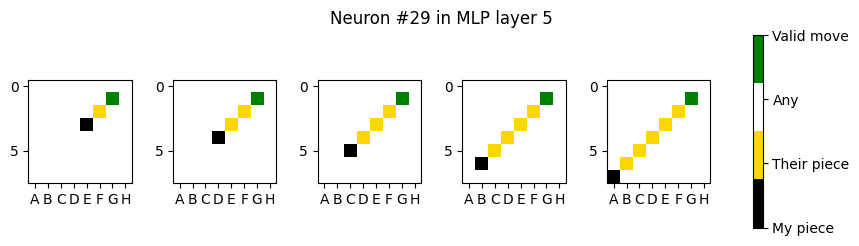

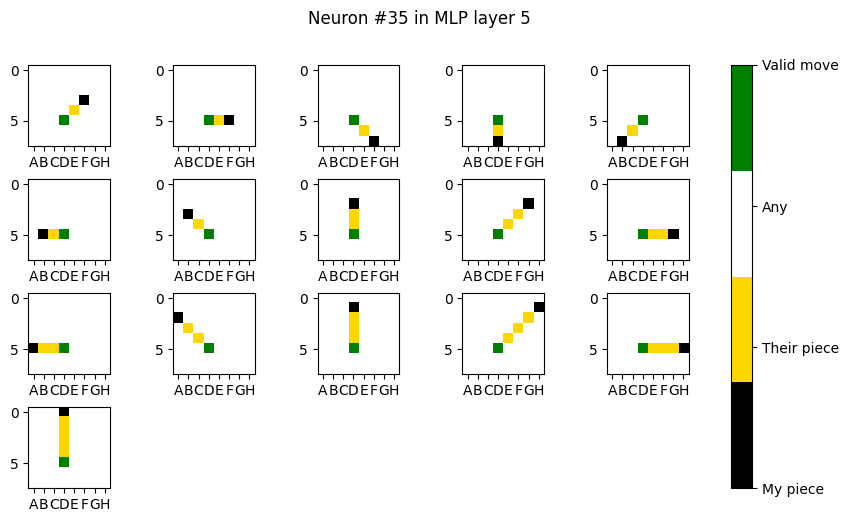

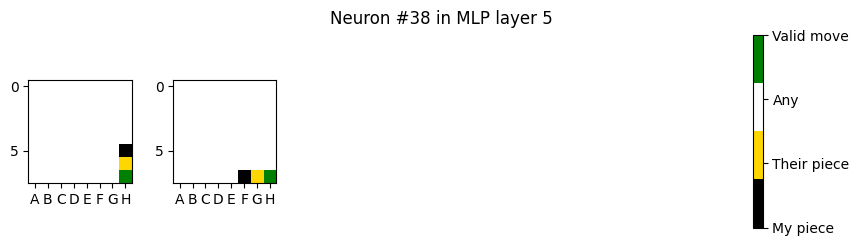

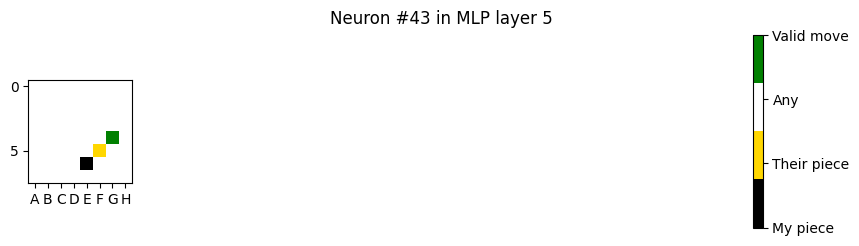

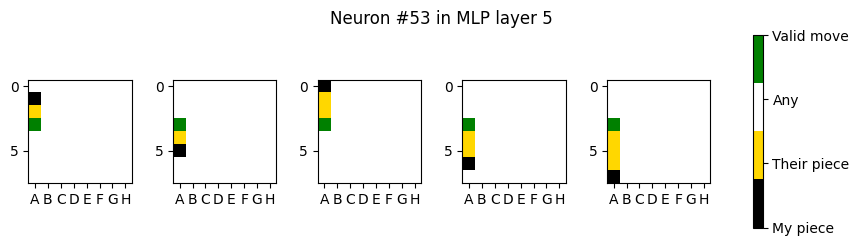

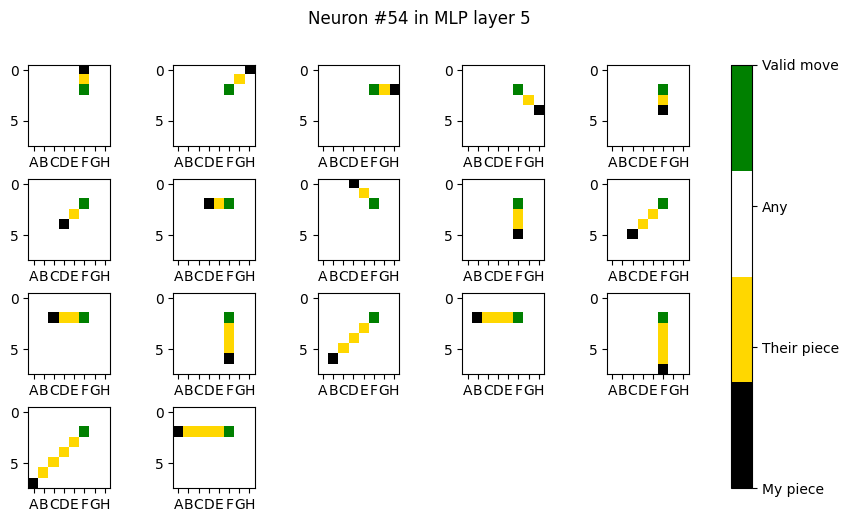

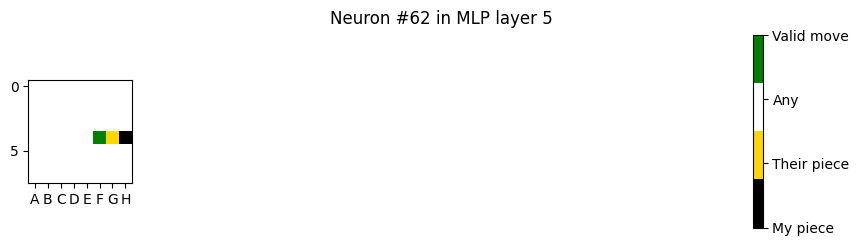

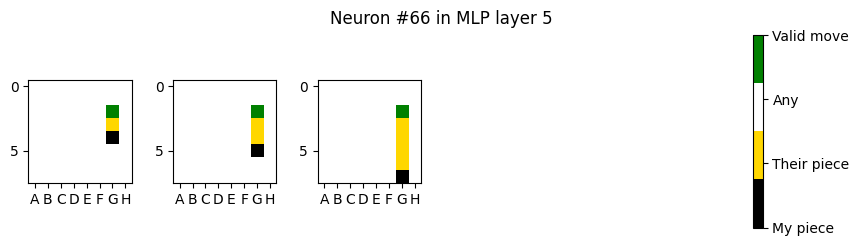

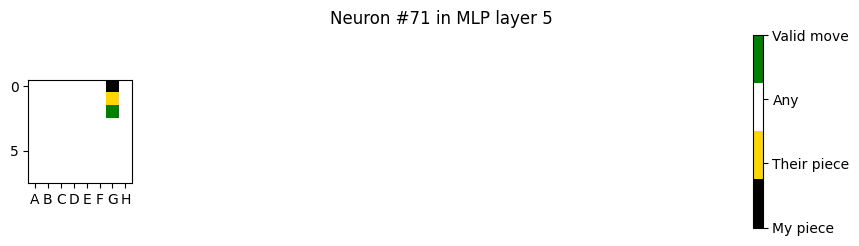

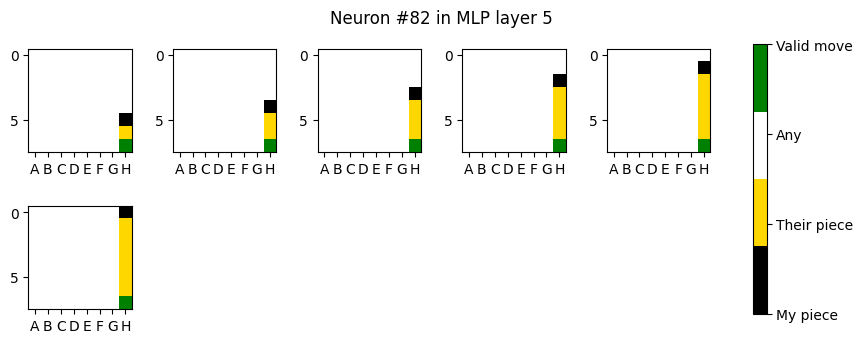

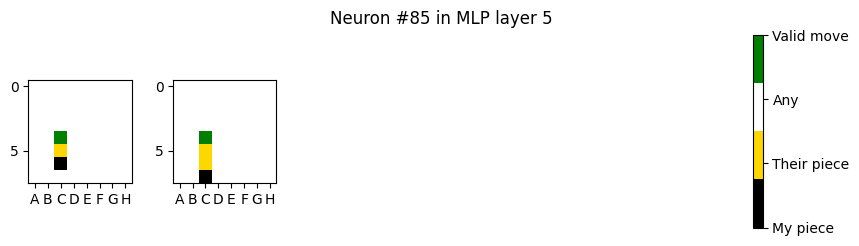

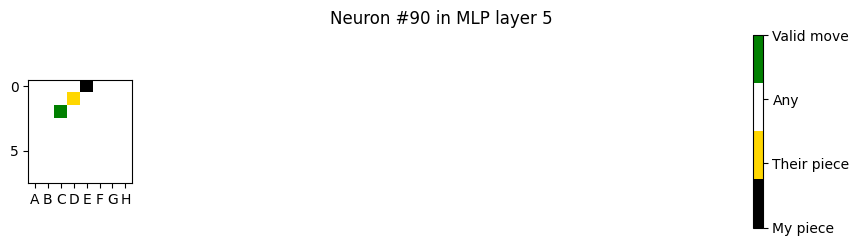

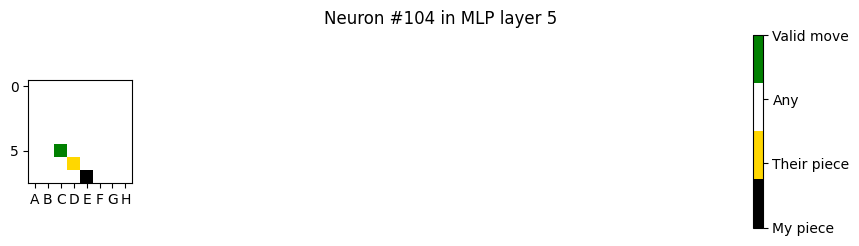

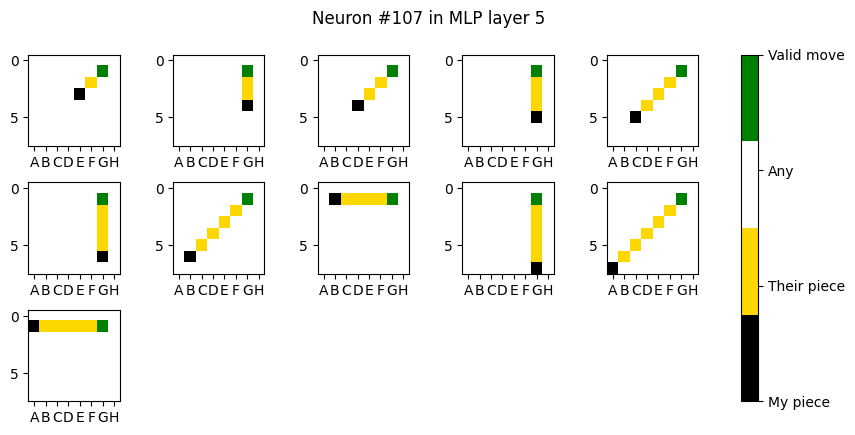

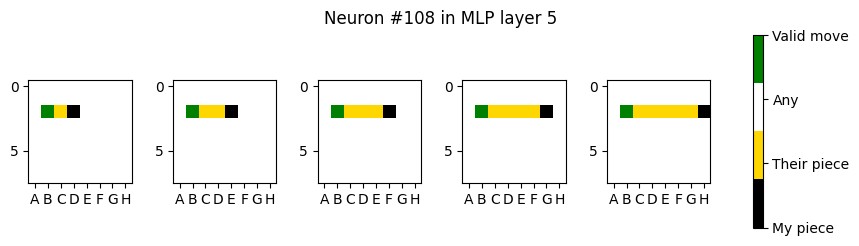

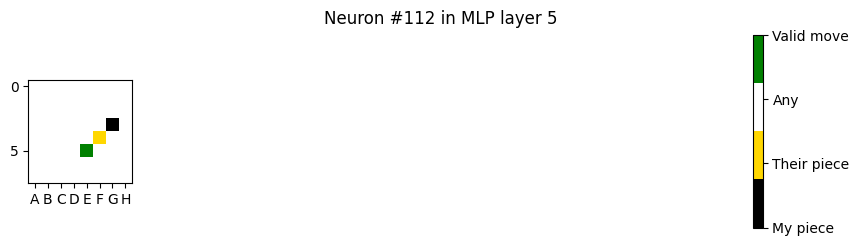

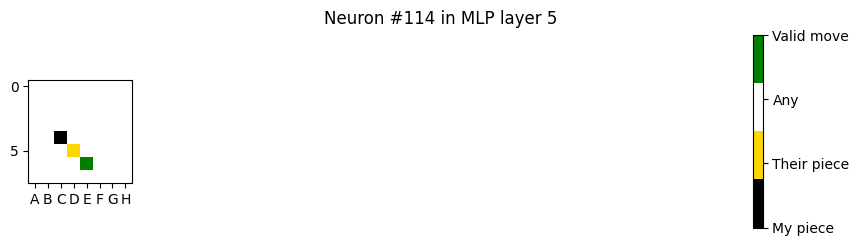

In [78]:
union_nonzero = union_FSLD.nonzero()
union_features = union_nonzero[:, 0].unique()

for j, feat_idx in enumerate(union_features):
    if j >= 20:
        break
    feature_idxs, square_idxs, lengths, directions = union_nonzero[union_nonzero[:, 0] == feat_idx].T
    boards = to_board_tensor(square_idxs, lengths, directions, device, opponent_only=False)

    plot_cols = 5
    plot_rows = (len(boards) + plot_cols-1) // plot_cols
    fig, axs = plt.subplots(plot_rows, plot_cols, figsize=(11, plot_rows+1.5))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between subplots
    fig.suptitle(f'Neuron #{feat_idx} in MLP layer {layer}')
    
    plot_board_categorical(fig, axs, boards.cpu().detach().numpy(), feature_idxs.cpu().detach().numpy(), node_type)
    # Remove empty subplots
    n_empty = plot_cols*plot_rows - len(boards)
    for i in range(n_empty):
        fig.delaxes(axs.flatten()[-i-1])

    plt.show()

### Plot max number of patterns making a move valid

Total number of valid lines: 1036


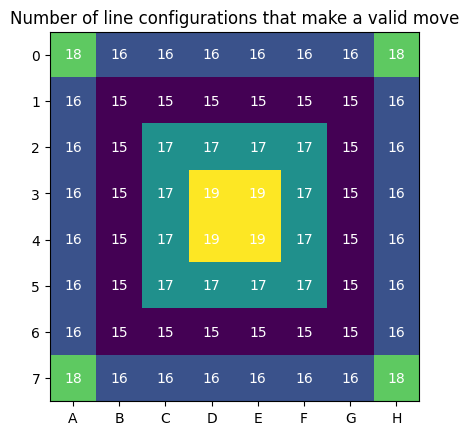

In [12]:
valid_idxs_SqLenDir = t.zeros((0, 3), dtype=t.int)
valid_board = t.zeros((8, 8), dtype=t.int)
for square_idx in range(64):
    r = square_idx // 8
    c = square_idx % 8
    for direction_idx, (dx, dy) in enumerate(eights):
        x, y = r + 2*dx, c + 2*dy
        length = 0
        while 0 <= x < 8 and 0 <= y < 8:
            idx_SqLenDir = t.tensor([square_idx, length, direction_idx], dtype=t.int).view(1, 3)
            valid_idxs_SqLenDir = t.cat([valid_idxs_SqLenDir, idx_SqLenDir], dim=0)
            valid_board[r, c] += 1
            # Update for next iteration
            x += dx
            y += dy
            length += 1

print(f'Total number of valid lines: {valid_board.sum()}')

# Plotting the valid_board
plt.imshow(valid_board.cpu().detach().numpy(), cmap='viridis')
plt.xticks(range(8))
plt.yticks(range(8))
plt.gca().set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])

# Annotate each square with its value
for i in range(valid_board.size(0)):
    for j in range(valid_board.size(1)):
        plt.text(j, i, f'{valid_board[i, j].item()}', ha='center', va='center', color='white')
plt.title('Number of line configurations that make a valid move')

plt.show()

### Plot fraction of patterns that correspond to board pattern neuron

In [86]:
import feature_viz_othello_utils
importlib.reload(feature_viz_othello_utils) 

node_type = "mlp_neuron"
T_high_corr = 0.9

In [89]:
# Fraction of patterns in layers 4,5,6
layer_idxs = [4, 5, 6]
union_LFSLD = t.zeros((0, 2048, 64, 6, 8), device=device)
for layer in layer_idxs:
    ae, ae_path = get_ae(layer, node_type)
    results = load_results_file(ae_path, device)
    union_FSLD = find_board_pattern_neurons(results, T_precision=T_high_corr, T_recall=T_high_corr, n_valid_moves_per_feat=1)
    union_LFSLD = t.cat([union_LFSLD, union_FSLD.unsqueeze(0)], dim=0)

fraction_patterns = union_LFSLD.any(dim=(0,1)).sum() / 1036
print(f'Fraction of patterns in layers {layer_idxs} for T_corr {T_high_corr}: {fraction_patterns}')

Fraction of patterns in layers [4, 5, 6] for T_corr 0.9: 0.9063706398010254


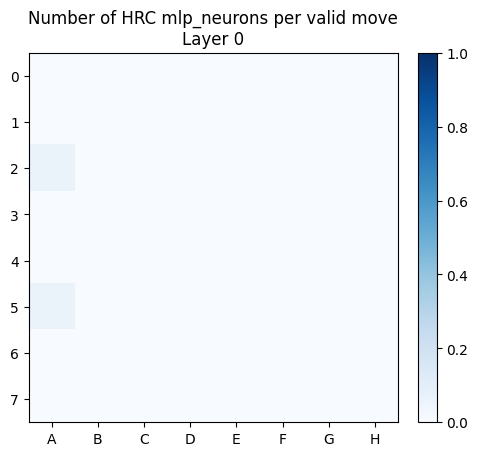

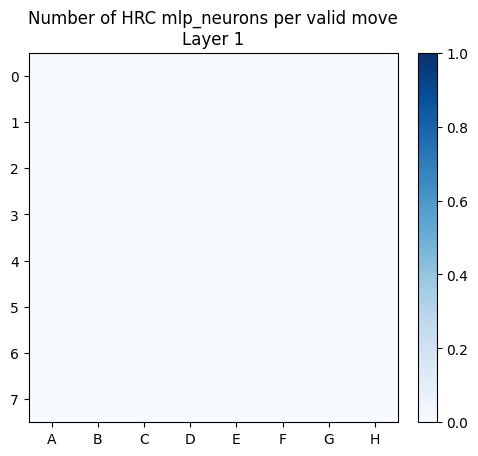

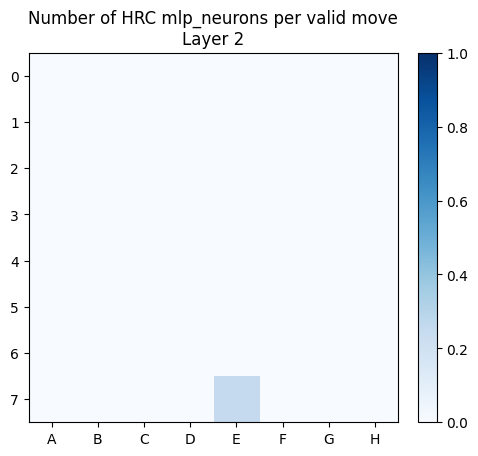

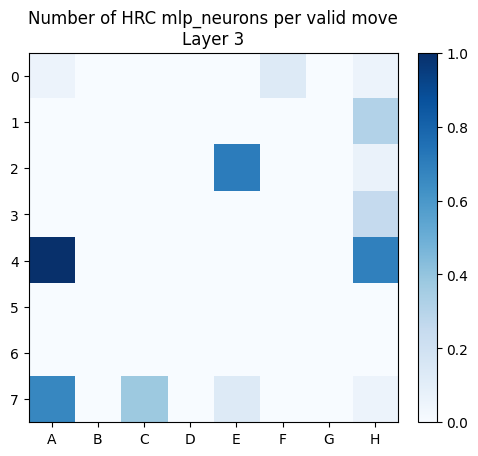

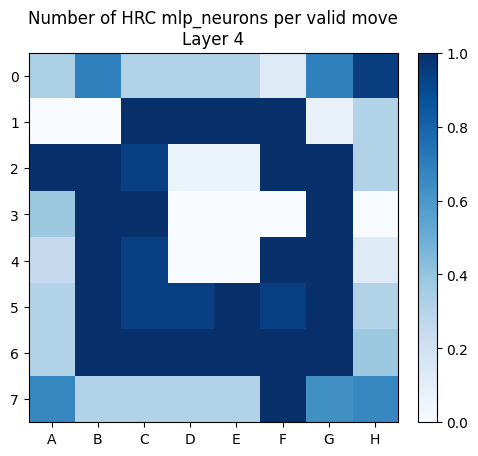

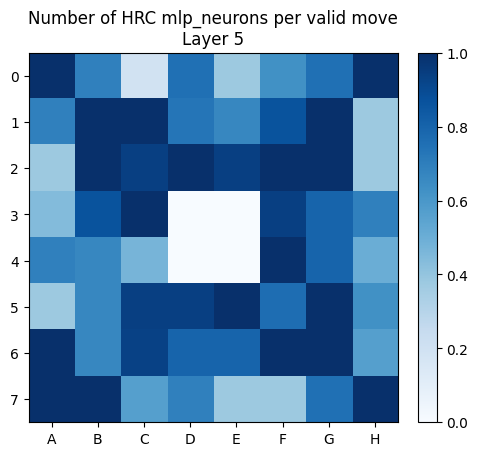

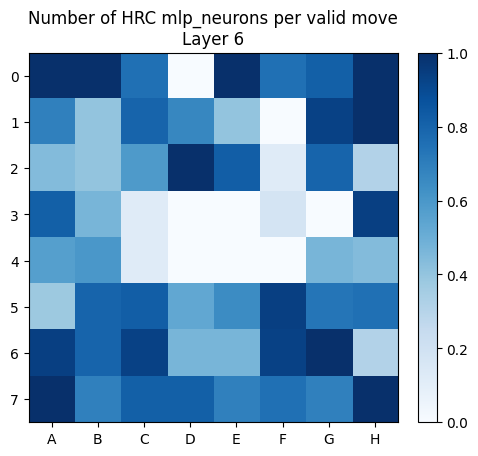

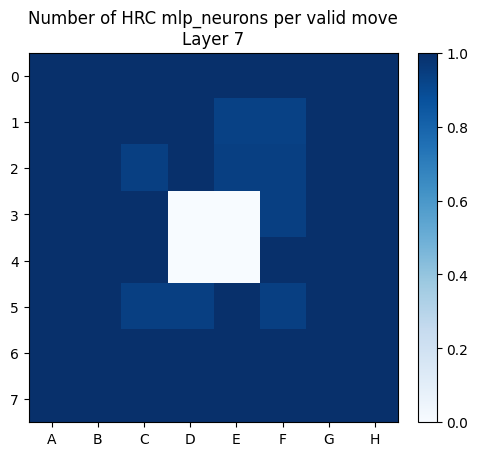

In [14]:


for layer in range(model.cfg.n_layers):
    ae, ae_path = get_ae(layer, node_type)
    results = load_results_file(ae_path, device)
    union_FSLD = find_board_pattern_neurons(results, T_precision=T_high_corr, T_recall=T_high_corr)

    patterns_per_square = union_FSLD.any(dim=0).sum(dim=(-2, -1)).reshape(8, 8).to('cpu').numpy()
    frac_patterns_per_square = patterns_per_square / valid_board

    fig, ax = plt.subplots()
    viz_utils.visualize_board_from_tensor(ax, frac_patterns_per_square, title=f'Number of HRC {node_type}s per valid move\nLayer {layer}', cmap='Blues', vmax=1)

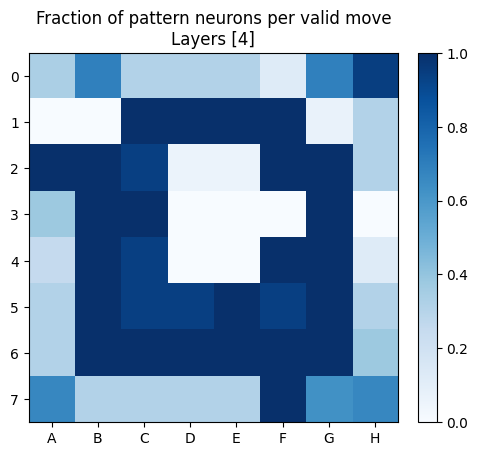

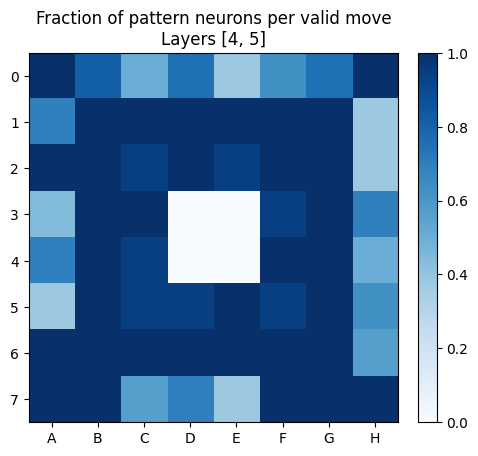

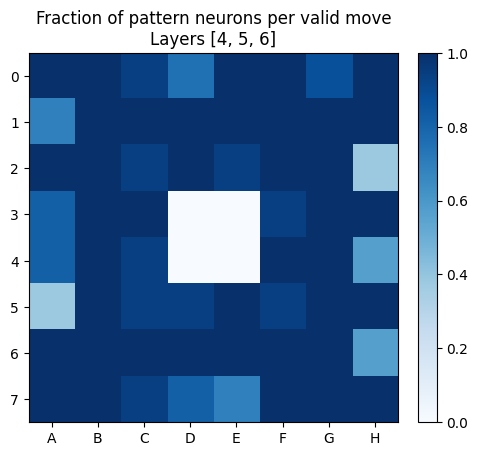

In [15]:
# Fraction for specific number of layers
layer_groups = [[4], [4,5], [4,5,6]]

for layers in layer_groups:
    n_patterns_per_feature = union_neurons_LFSLenDir[layers].any(dim=(0,1)).sum(dim=(-2, -1)).reshape(8,8).cpu().numpy()
    frac_patterns_per_feature = n_patterns_per_feature / valid_board

    fig, ax = plt.subplots()
    viz_utils.visualize_board_from_tensor(ax, frac_patterns_per_feature, title=f'Fraction of pattern neurons per valid move\nLayers {layers}', cmap='Blues', vmax=1)

### DLA of pattern neurons with logit corresponding to the legal move

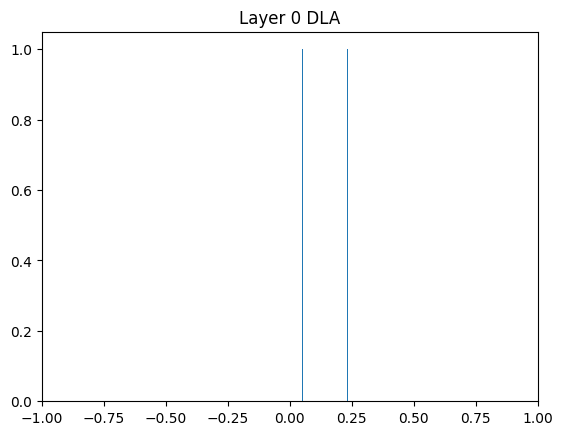

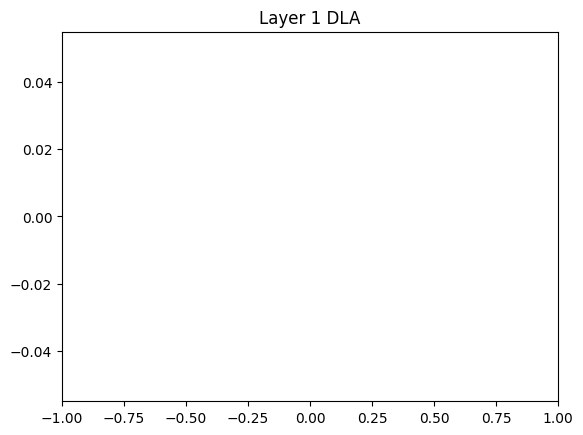

/tmp/ipykernel_361819/3853487712.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  unembed_vectors_DF = model.W_U.T[corresp_squares_i].T


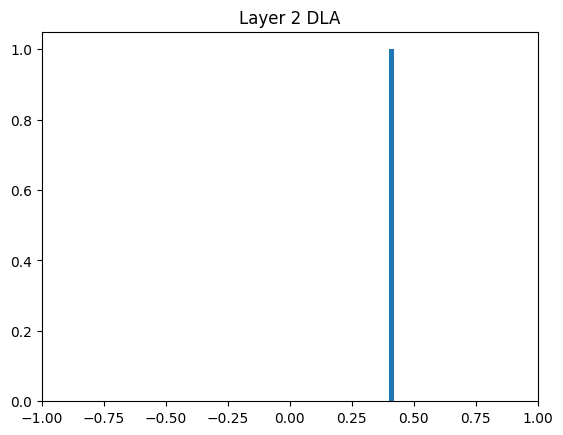

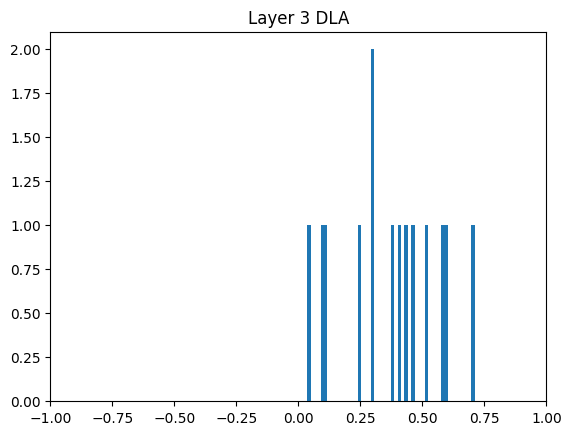

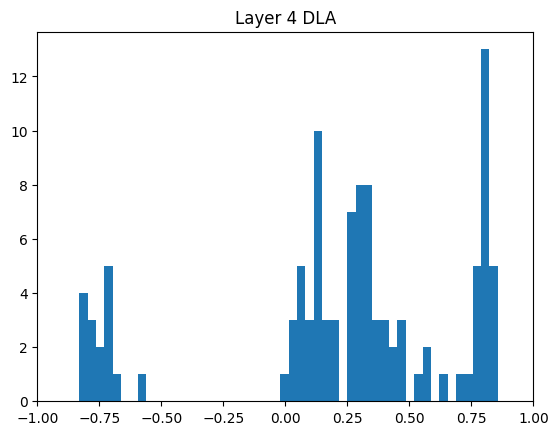

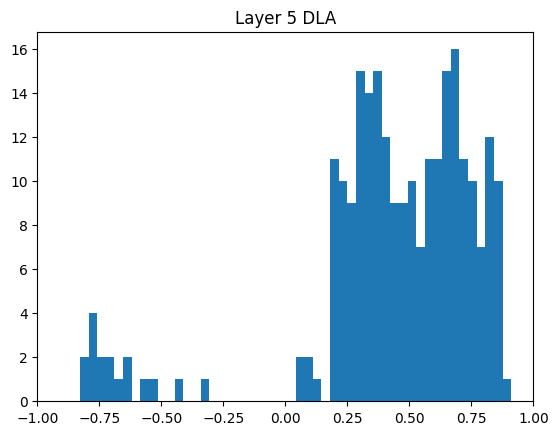

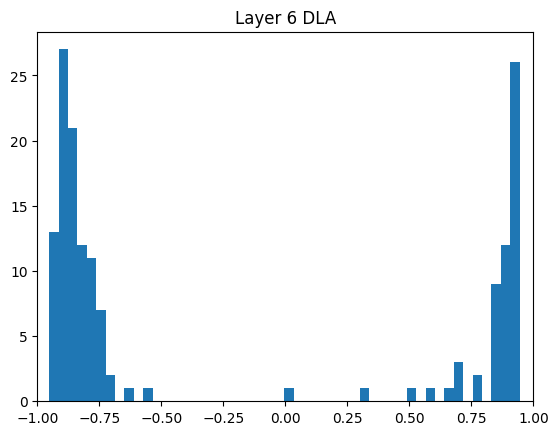

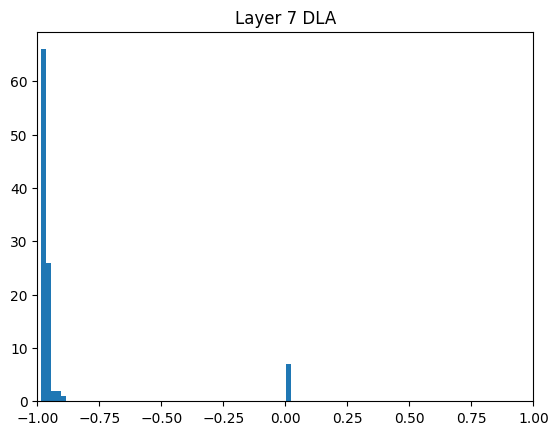

In [16]:
for layer in range(model.cfg.n_layers):
    union_features, corresp_squares_s = union_neurons_LFSLenDir[layer].any(dim=(-1, -2)).nonzero().T
    mlp_decoder_vectors_FD = model.W_out[layer][union_features]
    mlp_decoder_vectors_norm_F = t.norm(mlp_decoder_vectors_FD, dim=-1)
    mlp_decoder_vectors_normalized_FD = mlp_decoder_vectors_FD / mlp_decoder_vectors_norm_F.unsqueeze(-1)

    corresp_squares_i = to_int(corresp_squares_s)
    unembed_vectors_DF = model.W_U.T[corresp_squares_i].T
    unembed_vectors_norm_F = t.norm(unembed_vectors_DF, dim=0)
    unembed_vectors_normalized_DF = unembed_vectors_DF / unembed_vectors_norm_F

    dla = mlp_decoder_vectors_normalized_FD @ unembed_vectors_normalized_DF
    dla = t.diag(dla)
    plt.hist(dla.cpu().detach().numpy(), bins=50)
    plt.xlim(-1, 1)
    plt.title(f'Layer {layer} DLA')
    plt.show()

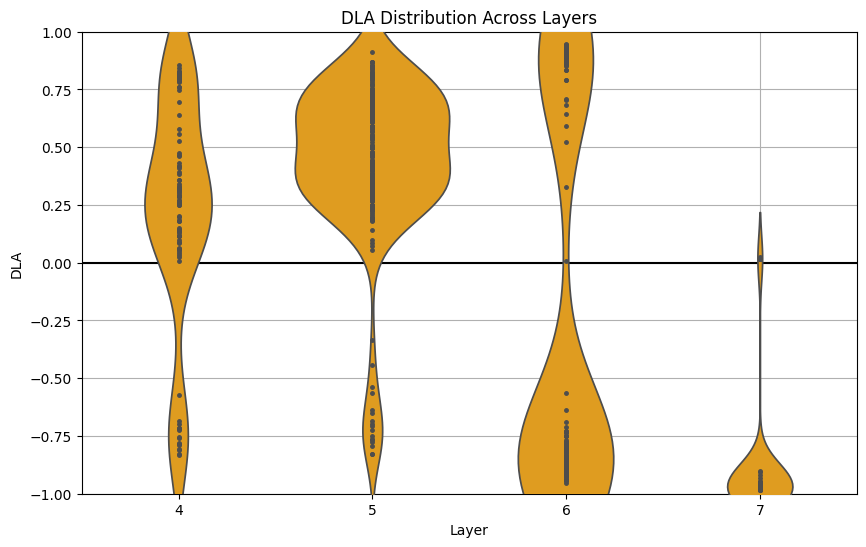

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch as t
import pandas as pd

# Accumulate the DLA data for each layer
dla_data = t.zeros((0,), device=device)
layers = t.zeros((0,), dtype=t.int, device=device)

for layer in range(4, model.cfg.n_layers):
    union_features, corresp_squares_s = union_neurons_LFSLenDir[layer].any(dim=(-1, -2)).nonzero().T
    mlp_decoder_vectors_FD = model.W_out[layer][union_features]
    mlp_decoder_vectors_norm_F = t.norm(mlp_decoder_vectors_FD, dim=-1)
    mlp_decoder_vectors_normalized_FD = mlp_decoder_vectors_FD / mlp_decoder_vectors_norm_F.unsqueeze(-1)

    corresp_squares_i = to_int(corresp_squares_s)
    unembed_vectors_DF = model.W_U.T[corresp_squares_i].T
    unembed_vectors_norm_F = t.norm(unembed_vectors_DF, dim=0)
    unembed_vectors_normalized_DF = unembed_vectors_DF / unembed_vectors_norm_F

    dla = mlp_decoder_vectors_normalized_FD @ unembed_vectors_normalized_DF
    dla = t.diag(dla)

    # Convert dla tensor to numpy array and accumulate data
    dla_data = t.hstack((dla_data, dla))
    layers = t.hstack((layers, t.ones_like(dla) * layer))

# Create a DataFrame for plotting
data = pd.DataFrame({'DLA': dla_data.cpu().detach().numpy(), 'Layer': layers.int().cpu().detach().numpy()})

# Create the violin plot
plt.figure(figsize=(10, 6))
plt.axhline(y=0, color='k', linestyle='-')
sns.violinplot(data=data, x='Layer', y='DLA', inner='point', orient='v', density_norm='count', zorder=10, color='orange')
plt.title('DLA Distribution Across Layers')
plt.xlabel('Layer')
plt.ylabel('DLA')
plt.ylim(-1, 1)
plt.grid()
plt.show()